In [8]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import gym
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

### First, we try a plain REINFORCE method.

In [50]:
env = gym.make('CartPole-v1')
EPISODE = 1000
GAMMA = 0.99

In [51]:
# helper reward function
def reward_generator(step, actions):
    batch_reward = np.ones((step+1,))
    batch_reward[-1] = -100
    for i in range(len(batch_reward)-2, -1, -1):
        batch_reward[i] += batch_reward[i+1] * GAMMA
    batch_reward -= np.mean(batch_reward)
    batch_reward /= np.std(batch_reward)
    advantages = np.zeros((step+1, 2))
    for i in range(step+1):
        advantages[i][actions[i]] = batch_reward[i] 
    return advantages

In [52]:
model = Sequential([
    Dense(24, input_dim = 4, kernel_initializer='glorot_uniform', activation='relu'),
    Dense(48, kernel_initializer='glorot_uniform', activation='relu'),
    Dense(64,  kernel_initializer='glorot_uniform', activation='relu'),
    Dense(2, activation = 'softmax')
])
model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy')



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



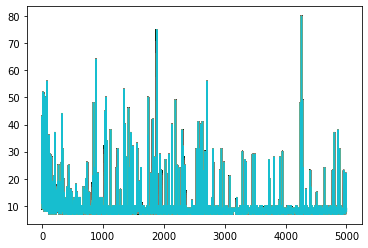

In [53]:
observation = env.reset()
steps = []
for episode in range(5000):
    observations = []
    actions = []
    for step in range(999):
        output = model(tf.expand_dims(observation, axis = 0))
        action = np.random.choice(2, p = np.array(output[0]))
        actions.append(action)
        observation, reward, done, info = env.step(action)
        observations.append(observation)
        if done:
            steps.append(step)
            print(f'episode {episode}, step {step}',end='\r')
            advantages = reward_generator(step, actions)
            model.fit(np.array(observations), advantages, epochs = 1, verbose = 0)
            observation = env.reset()
            break
    plt.plot(steps)

In [39]:
reward_generator(10,[0]*11)

array([[10.46617457,  0.        ],
       [ 9.5617925 ,  0.        ],
       [ 8.64827525,  0.        ],
       [ 7.72553056,  0.        ],
       [ 6.79346521,  0.        ],
       [ 5.85198506,  0.        ],
       [ 4.90099501,  0.        ],
       [ 3.940399  ,  0.        ],
       [ 2.9701    ,  0.        ],
       [ 1.99      ,  0.        ],
       [ 1.        ,  0.        ]])

In [48]:
import sys
import gym
import pylab
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

EPISODES = 1000


# This is Policy Gradient agent for the Cartpole
# In this example, we use REINFORCE algorithm which uses monte-carlo update rule
class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.hidden1, self.hidden2 = 24, 24

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_reinforce.h5")

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        model.summary()
        # Using categorical crossentropy as a loss is a trick to easily
        # implement the policy gradient. Categorical cross entropy is defined
        # H(p, q) = sum(p_i * log(q_i)). For the action taken, a, you set 
        # p_a = advantage. q_a is the output of the policy network, which is
        # the probability of taking the action a, i.e. policy(s, a). 
        # All other p_i are zero, thus we have H(p, q) = A * log(policy(s, a))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=self.learning_rate))
        return model

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        episode_length = len(self.states)
        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        update_inputs = np.zeros((episode_length, self.state_size))
        advantages = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            update_inputs[i] = self.states[i]
            advantages[i][self.actions[i]] = discounted_rewards[i]
        self.model.fit(update_inputs, advantages, epochs=1, verbose=0)
        self.states, self.actions, self.rewards = [], [], []

def main():
    # In case of CartPole-v1, you can play until 500 time step
    env = gym.make('CartPole-v0')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # make REINFORCE agent
    agent = REINFORCEAgent(state_size, action_size)

    scores, episodes = [], []
    steps = []
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        for step in range(200):
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100
            
            # save the sample <s, a, r> to the memory
            agent.append_sample(state, action, reward)
            score += reward
            state = next_state

            if done:
                # every episode, agent learns from sample returns
                agent.train_model()
                steps.append(step)
                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                print("episode:", e, "  steps", step, end = '\r')
                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                break
    plt.plot(steps)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_52 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
245   steps 7episode: 247   steps 17episode: 249   steps 8episode: 251   steps 13episode: 253   steps 18episode: 255   steps 7episode: 257   steps 20episode: 259   steps 14episode: 261   steps 9episode: 263   steps 11episode: 265   steps 21episode: 267   steps 13episode: 269   steps 12episode: 271   steps 10episode: 273   steps 17episode: 275   steps 8episode: 277   steps 10episode:

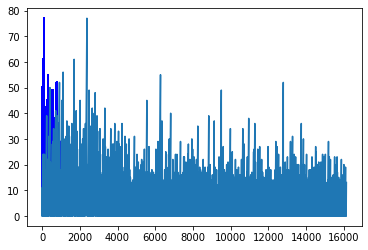

In [49]:
main()